In [9]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import datetime

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config_hlwas_coadd.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config_hlwas_coadd.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util

survey_params = util.hydra_to_dict(config.survey)

In [10]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = True

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_coadd'

print(f'pipeline_dir: {pipeline_dir}')

pipeline_dir: /data/bwedig/mejiro/pipeline_coadd


# Detectable and candidate lens counts

Number of detectable strong lenses per square degree of simulated area, candidate strong lenses

In [11]:
# combine CSVs from each run into one CSV
data_dir = os.path.join(pipeline_dir, '00')

detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
util.delete_if_exists(detectable_csv)
detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)

if survey_params['total_population']:
    total_csv = os.path.join(data_dir, 'total_pop.csv')
    util.delete_if_exists(total_csv)
    total_df = util.combine_all_csvs(data_dir, 'total', total_csv)

Wrote combined CSV to /data/bwedig/mejiro/pipeline_coadd/00/detectable_pop.csv
Wrote combined CSV to /data/bwedig/mejiro/pipeline_coadd/00/total_pop.csv


In [ ]:
# Calculate the number of rows before filtering
rows_before_detectable = len(detectable_df)

# Remove rows with 'snr' as np.inf
detectable_df = detectable_df[~np.isinf(detectable_df['snr'])]
rows_removed_detectable = rows_before_detectable - len(detectable_df)
print(f'Rows removed from detectable_df: {rows_removed_detectable}')

Rows removed from detectable_df: 0
Rows removed from total_df: 0


In [13]:
survey_area = survey_params['area']
runs = survey_params['runs']

total_area = survey_area * runs
print(f'{runs} run(s) of {survey_area} sq. deg. each gives {total_area:.2f} sq. deg. total')

54 run(s) of 0.5 sq. deg. each gives 27.00 sq. deg. total


In [14]:
print(f'{len(detectable_df)} detectable strong lenses')

if survey_params['total_population']:
    print(f'{len(total_df)} total candidate strong lenses')
    fraction_detectable = len(detectable_df) / len(total_df)
    print(f'Fraction of candidate strong lenses that are detectable: {fraction_detectable:.5f}')

8128 detectable strong lenses
463942 total candidate strong lenses
Fraction of candidate strong lenses that are detectable: 0.01752


In [15]:
det_per_sq_deg = len(detectable_df) / total_area
print(f'Detectable strong lenses per sq. deg.: {det_per_sq_deg:.2f}')

if survey_params['total_population']:
    total_per_sq_deg = len(total_df) / total_area
    print(f'Candidate strong lenses per sq. deg.: {round(total_per_sq_deg)}')

Detectable strong lenses per sq. deg.: 301.04
Candidate strong lenses per sq. deg.: 17183


In [16]:
det_per_exposure = det_per_sq_deg * 0.281
print(f'Detectable strong lenses per exposure: {det_per_exposure:.2f}')

Detectable strong lenses per exposure: 84.59


In [17]:
snr_threshold = 200
high_snr_df = detectable_df[detectable_df['snr'] > snr_threshold]
high_snr_det_per_sq_deg = len(high_snr_df) / total_area
high_snr_det_per_exposure = high_snr_det_per_sq_deg * 0.281

print(f'{len(high_snr_df)} characterizable strong lenses (SNR > {snr_threshold})')
print(f'{high_snr_det_per_sq_deg:.2f} characterizable per sq. deg.')
print(f'Characterizable strong lenses per exposure: {high_snr_det_per_exposure:.2f}')

89 characterizable strong lenses (SNR > 200)
3.30 characterizable per sq. deg.
Characterizable strong lenses per exposure: 0.93


In [18]:
# HLWAS
print(f'{round(det_per_sq_deg * 1700)} detectable strong lenses in HLWAS')
print(f'{round(high_snr_det_per_sq_deg * 1700)} characterizable strong lenses in HLWAS')

511763 detectable strong lenses in HLWAS
5604 characterizable strong lenses in HLWAS


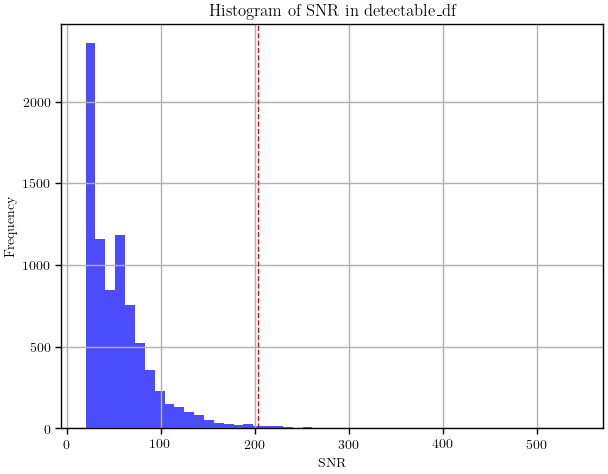

In [21]:
plt.hist(detectable_df['snr'], bins=50, color='blue', alpha=0.7)
plt.axvline(np.percentile(detectable_df['snr'], 99), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('Histogram of SNR in detectable_df')
plt.grid(True)
plt.show()